In [ ]:
# Requirements
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from sqlalchemy import create_engine
from itables import init_notebook_mode

init_notebook_mode(all_interactive=False)

<IPython.core.display.Javascript object>

In [ ]:
# Titanic data set path
path = "titanic.csv"

# Creating a Connection

## Through PostgreSQL

In [ ]:
# Connect to your database through postgresql
conn_credentials = "" # String: "host= port= dbname= user= password="
conn = psycopg2.connect(conn_credentials)

# Make changes effective to the database
conn.autocommit = True

# Open a cursor to perform database operations
cur = conn.cursor()

## Through SQL Alchemy

In [4]:
# String: dialect[+driver]://user:password@host/dbname[?key=value..]
engine_credentials = ""
engine = create_engine(engine_credentials, echo=False)

# Query to DataFrame

## Creating a Function Wrapper

In [5]:
# Convert query to a DataFrame

# Child Function
def execute_query(fn):
    # Wrapper
    def inner(query):
        global sql_df
        # Execute query through the parent function
        try:
            fn(query)
        except Exception as e:
            print(e)
        # Try to fetch and return a DataFrame
        try:
            fetch = cur.fetchall()
            colnames = [colname[0] for colname in cur.description]  
            sql_df = pd.DataFrame(fetch, columns=colnames) 
            return sql_df 
        # Still prints if no DataFrame is returned
        except Exception as e:
            print(f"Query executed sucessfully: {e}")  
    return inner

execute_query = execute_query(cur.execute)

## Using ***read_sql*** method with SQL alchemy"s connection

* Slower

In [6]:
# Convert query to a DataFrame using Pandas read_sql method with SQL Alchemy connection
def execute_query_engine(query: str, con=engine):
    try:
        return pd.read_sql_query(query, con=engine)
    except Exception as e:
        print(e)

## Using ***read_sql*** method with PostgreSQL connection

* Works but Throws a UserWarning

In [7]:
# Convert query to a DataFrame using Pandas read_sql method with PostgreSQL connection
def execute_query_postgresql(query: str, con=conn):
    try:
        return pd.read_sql_query(query, con=conn)
    except Exception as e:
        print(e)

# Queries

## Server Description

### Schema

In [8]:
# Get all schemas
query = """

SELECT schema_name
FROM information_schema.schemata

"""

execute_query(query)

,schema_name
0,pg_catalog
1,public
2,information_schema


### Users

In [ ]:
# Get Users and their privileges
query = """

SELECT usename AS role_name,
 CASE
  WHEN usesuper AND usecreatedb THEN
    CAST("superuser, create database" AS pg_catalog.text)
  WHEN usesuper THEN
    CAST("superuser" AS pg_catalog.text)
  WHEN usecreatedb THEN
    CAST("create database" AS pg_catalog.text)
  ELSE
    CAST("" AS pg_catalog.text)
 END role_attributes
FROM pg_catalog.pg_user
ORDER BY role_name desc;

"""

execute_query(query)

,role_name,role_attributes
0,yulieth,
1,ricardo,
2,postgres,"superuser, create database"
3,nerio,
4,leidys,
5,jorge,
6,eliecer,
7,betsuite,


### Tables from Schema

In [ ]:
# Get Tables from a particular schema
query = """

SELECT *
FROM information_schema.tables
WHERE table_schema = "public"

"""

execute_query(query)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,jorge,public,titanic,BASE TABLE,None,None,None,None,None,YES,NO,None


## Delete Tables

In [11]:
# Drop Tables
query = """

DROP TABLE IF EXISTS classes,
classes_students_relation,
users,
users_teachers,
users_students,
persons,
titanic	

"""

execute_query(query)

Query executed sucessfully: no results to fetch


## Create Tables

In [12]:
# Create Table
query = """

CREATE TABLE IF NOT EXISTS titanic (
id SERIAL,
survived BIT(1),
pclass BIT(1),
sex CHAR(6),
age INT4,
sibsp BIT(1),
parch BIT(1),
fare FLOAT8,
embarked CHAR(1),
class VARCHAR,
who CHAR(5),
adult_male BOOLEAN,
deck CHAR(1),
embark_town VARCHAR,
alive CHAR(3),
alone BOOLEAN,
PRIMARY KEY (id)
)

"""

# execute_query(query)

## Import 

### Method 1 - Through Adapter

In [ ]:
# Create table then import
query = f"""

COPY public.titanic
FROM "C:\\users\\aldan\\escritorio\\study notes\\0 - Data Sets\\titanic.csv"
DELIMITER ","
CSV HEADER

"""

execute_query(query)

must be superuser or a member of the pg_read_server_files role to COPY from a file
HINT:  Anyone can COPY to stdout or from stdin. psql's \copy command also works for anyone.

Query executed sucessfully: no results to fetch


### Method 2 Through SQL Alchemy

In [14]:
# Import as Pandas DataFrame
(df := pd.read_csv(path)).head(3)

,Unnamed: 0,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


In [ ]:
# Import Pandas DataFrame to SQL Server
try:
    df.to_sql("titanic", con=engine)
except Exception as e:
    print(e)

## Table EDA

### Table Data Types

In [ ]:
# Data types
query = """

SELECT 
   table_name, 
   column_name, 
   data_type 
FROM 
   information_schema.columns
WHERE 
   table_name = "titanic"
ORDER BY
   data_type
"""

execute_query(query)

,table_name,column_name,data_type
0,titanic,sibsp,bigint
1,titanic,Unnamed: 0,bigint
2,titanic,survived,bigint
3,titanic,pclass,bigint
4,titanic,index,bigint
5,titanic,parch,bigint
6,titanic,alone,boolean
7,titanic,adult_male,boolean
8,titanic,fare,double precision
9,titanic,age,double precision


<AxesSubplot:xlabel='data_type', ylabel='column_name'>

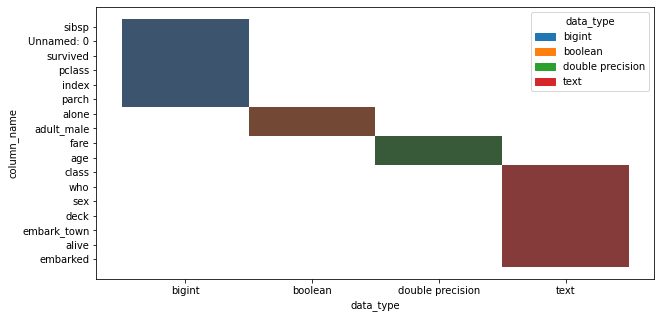

In [ ]:
# Data types plot
plt.figure(figsize=(10, 5))
sql_df.sort_values(by="data_type", ascending=True)
sns.histplot(y="column_name", x="data_type", data=sql_df, hue="data_type")

### Table Distinct

In [18]:
# Get all records from the table
query = """

SELECT *
FROM titanic

"""

execute_query(query)

,index,Unnamed: 0,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,None,Southampton,no,False
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,None,Southampton,yes,True
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,None,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,None,Southampton,no,True
887,887,887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,888,888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,None,Southampton,no,False
889,889,889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [19]:
# Column names
(titanic_columns := list(sql_df.columns))

['index',
 'Unnamed: 0',
 'survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alive',
 'alone']

,survived,count_of_distinct_values
0,0,549
1,1,342


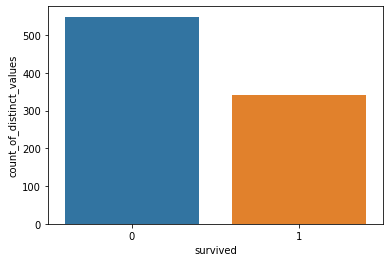

,pclass,count_of_distinct_values
0,3,491
1,1,216
2,2,184


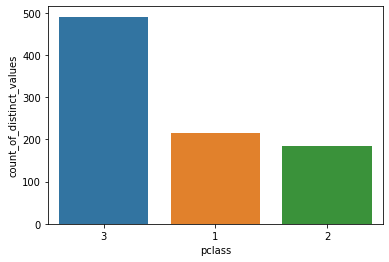

,sex,count_of_distinct_values
0,male,577
1,female,314


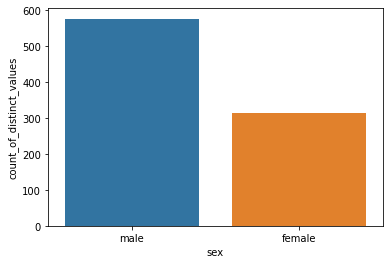

,age,count_of_distinct_values
0,None,177
1,24,30
2,22,27
3,18,26
4,28,25
5,30,25
6,19,25
7,21,24
8,25,23
9,36,22


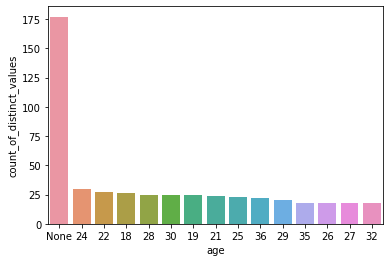

,sibsp,count_of_distinct_values
0,0,608
1,1,209
2,2,28
3,4,18
4,3,16
5,8,7
6,5,5


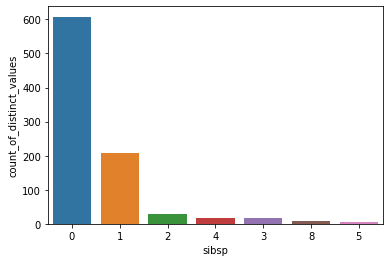

,parch,count_of_distinct_values
0,0,678
1,1,118
2,2,80
3,5,5
4,3,5
5,4,4
6,6,1


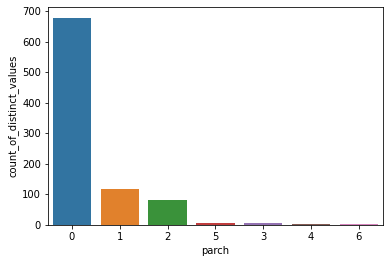

,fare,count_of_distinct_values
0,8.05,43
1,13,42
2,7.8958,38
3,7.75,34
4,26,31
5,10.5,24
6,7.925,18
7,7.775,16
8,7.2292,15
9,26.55,15


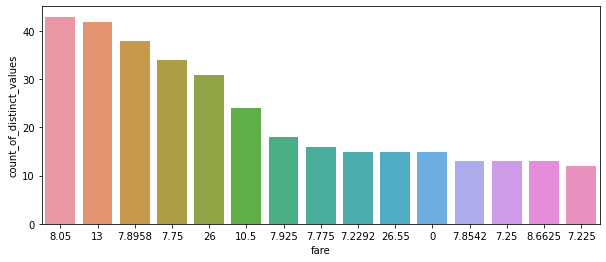

,embarked,count_of_distinct_values
0,S,644
1,C,168
2,Q,77
3,None,2


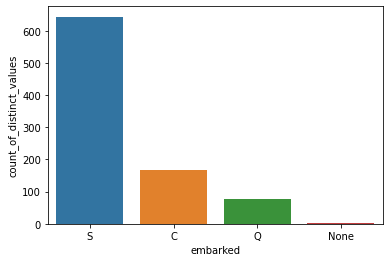

,class,count_of_distinct_values
0,Third,491
1,First,216
2,Second,184


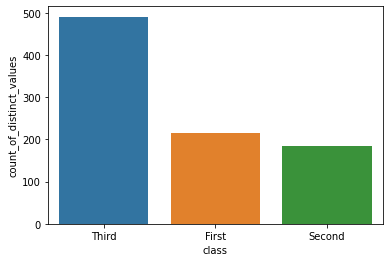

,who,count_of_distinct_values
0,man,537
1,woman,271
2,child,83


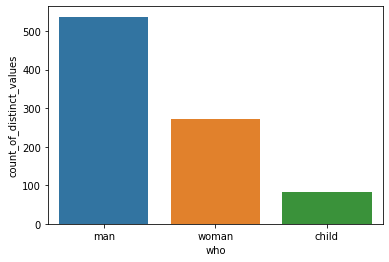

,adult_male,count_of_distinct_values
0,true,537
1,false,354


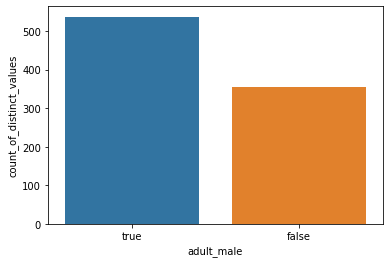

,deck,count_of_distinct_values
0,None,688
1,C,59
2,B,47
3,D,33
4,E,32
5,A,15
6,F,13
7,G,4


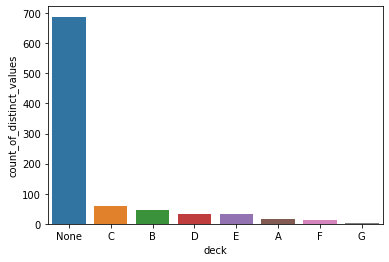

,embark_town,count_of_distinct_values
0,Southampton,644
1,Cherbourg,168
2,Queenstown,77
3,None,2


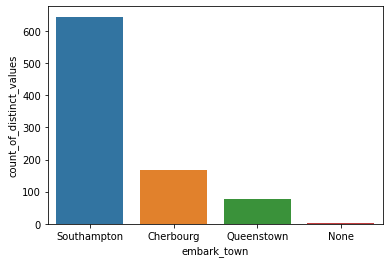

,alive,count_of_distinct_values
0,no,549
1,yes,342


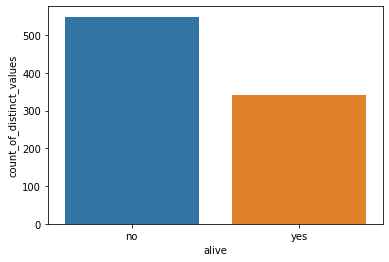

,alone,count_of_distinct_values
0,true,537
1,false,354


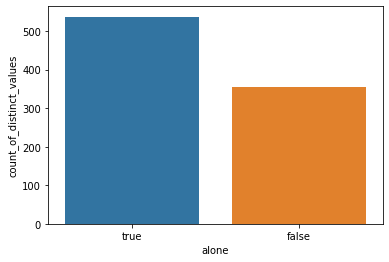

In [ ]:
# Count of Unique Values per field
for col in titanic_columns[2:]:

    query = f"""

    SELECT
        CASE WHEN CAST({col} AS VARCHAR(20)) IS NULL 
                THEN "None"
                ELSE CAST({col} AS VARCHAR(20))
        END AS {col},
        COUNT(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS count_of_distinct_values
    FROM titanic
    GROUP BY {col}
    ORDER BY count_of_distinct_values DESC
    LIMIT 15

    """
# Display tabular data as DataFrame
    display(execute_query(query))

# Customized plot per field
    if col == "fare":
            plt.figure(figsize=(10,4))

# Plot count of unique values per field
    sns.barplot(
        data = sql_df, 
        x    = col, 
        y    = "count_of_distinct_values"
    )
    
    plt.show()

### Spotted Problems

* Delete Unnamed: 0
* Delete adult_male 
* Delete 'sibsp' and 'parch'
* age has NaN and floats
* embarked has none
* embark_town has None
* embarked == embark_town ?
* pclass == class ?
* survived == alive
* fare has outliers

## Table - Data Cleaning

### Deleting Fields

* Delete Unnamed: 0
* Delete adult_male 
* Delete 'sibsp' and 'parch'
* Delete alive

In [21]:
# Deleting redundant columns: unnamed: 0, adult_male, sibsp, parch
query = """

ALTER TABLE titanic
    DROP COLUMN "Unnamed: 0",
    DROP COLUMN adult_male,
    DROP COLUMN sibsp,
    DROP COLUMN parch,
    DROP COLUMN alive

"""

execute_query(query)

Query executed sucessfully: no results to fetch


In [22]:
# Checking changes
query = """

SELECT *
FROM titanic

"""

list(execute_query(query).columns)

['index',
 'survived',
 'pclass',
 'sex',
 'age',
 'fare',
 'embarked',
 'class',
 'who',
 'deck',
 'embark_town',
 'alone']

### Dealing with Missing Values

* age has NaN and floats
* embarked has none
* embark_town has None
* deck

#### age

In [23]:
# Count of null and non-null values for embarked
query = """

SELECT 
    SUM(CASE WHEN age IS NULL THEN 1 ELSE 0 END) 
    AS "Number Of Null Values", COUNT(age) AS "Number Of Non-Null Values"
FROM titanic

"""

execute_query(query)

,Number Of Null Values,Number Of Non-Null Values
0,177,714


In [24]:
# Selecting age from float as int4
query = """

SELECT CAST(age AS INT4)
FROM titanic

"""

execute_query(query)

,age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
...,...
886,27.0
887,19.0
888,NaN
889,26.0


In [25]:
# Converting from float to int4
query = """

ALTER TABLE titanic
ALTER COLUMN age TYPE INT4

"""

execute_query(query)

Query executed sucessfully: no results to fetch


In [26]:
# Checking changes
query = """

SELECT age
FROM titanic

"""

execute_query(query)

,age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
...,...
886,27.0
887,19.0
888,NaN
889,26.0


In [ ]:
# Replacing null values with mean
mean_age = sql_df["age"].mean()

query = f"""

UPDATE titanic
SET age = {mean_age}
WHERE age IS NULL

"""

execute_query(query)

Query executed sucessfully: no results to fetch


In [28]:
# Checking null values
query = """

SELECT *
FROM titanic
WHERE age IS NULL

"""

execute_query(query)

,index,survived,pclass,sex,age,fare,embarked,class,who,deck,embark_town,alone


In [29]:
# Rounding age 0 to 1
query = f"""

UPDATE titanic
SET age = 1
WHERE age = 0

"""

execute_query(query)

Query executed sucessfully: no results to fetch


In [30]:
# Checking changes
query = f"""

SELECT age
FROM titanic

"""

execute_query(query)

,age
0,22
1,38
2,26
3,35
4,35
...,...
886,30
887,30
888,30
889,30


In [31]:
# Checking age-who distribution
query = f"""

SELECT age, who
FROM titanic

"""

execute_query(query)

,age,who
0,22,man
1,38,woman
2,26,woman
3,35,woman
4,35,man
...,...,...
886,30,man
887,30,woman
888,30,man
889,30,man


In [ ]:
# Women and Men classification starts at 16 years old, Child limit age is 15 years old, with minimum of 1
sns.violinplot(x="who", y="age", data=sql_df)
plt.ylim(0, 20)
plt.yticks(range(0, 20, 1))
plt.show()

#### embarked and embark_town

In [33]:
# Count of null and non-null values for embarked
query = """

SELECT 
    SUM(CASE WHEN embarked IS NULL THEN 1 ELSE 0 END) 
    AS "Number Of Null Values", COUNT(embarked) AS "Number Of Non-Null Values"
FROM titanic

"""

execute_query(query)

,Number Of Null Values,Number Of Non-Null Values
0,2,889


In [34]:
# Count of null and non-null values for embark_town
query = """

SELECT 
    SUM(CASE WHEN embark_town IS NULL THEN 1 ELSE 0 END) 
    AS "Number Of Null Values", COUNT(embark_town) AS "Number Of Non-Null Values"
FROM titanic

"""

execute_query(query)

,Number Of Null Values,Number Of Non-Null Values
0,2,889


In [35]:
# Rows with null values for embarked
query = """

SELECT 
    embarked, embark_town
FROM titanic
WHERE embarked IS NULL

"""

execute_query(query)

,embarked,embark_town
0,None,None
1,None,None


In [36]:
# Deleting null values for embarked and embark_town which are in the same row
query = """

DELETE FROM titanic 
WHERE embarked IS NULL

"""

execute_query(query)

Query executed sucessfully: no results to fetch


In [37]:
# Checking the changes
query = """

SELECT 
    embarked, embark_town
FROM titanic
WHERE embarked IS NULL

"""

execute_query(query)

,embarked,embark_town


#### deck

In [38]:
# Count of null and non-null values for deck
query = """

SELECT 
    SUM(CASE WHEN deck IS NULL THEN 1 ELSE 0 END) 
    AS "Number Of Null Values", COUNT(deck) AS "Number Of Non-Null Values"
FROM titanic

"""

execute_query(query)

,Number Of Null Values,Number Of Non-Null Values
0,688,201


In [39]:
# Deleting deck column because too much nulls and no useful idea on how to fill them
query = """

ALTER TABLE titanic
DROP COLUMN deck

"""

execute_query(query)

Query executed sucessfully: no results to fetch


In [40]:
# Checking the changes
query = """

SELECT *
FROM titanic

"""

execute_query(query)

,index,survived,pclass,sex,age,fare,embarked,class,who,embark_town,alone
0,0,0,3,male,22,7.2500,S,Third,man,Southampton,False
1,1,1,1,female,38,71.2833,C,First,woman,Cherbourg,False
2,2,1,3,female,26,7.9250,S,Third,woman,Southampton,True
3,3,1,1,female,35,53.1000,S,First,woman,Southampton,False
4,4,0,3,male,35,8.0500,S,Third,man,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...
884,859,0,3,male,30,7.2292,C,Third,man,Cherbourg,True
885,863,0,3,female,30,69.5500,S,Third,woman,Southampton,False
886,868,0,3,male,30,9.5000,S,Third,man,Southampton,True
887,878,0,3,male,30,7.8958,S,Third,man,Southampton,True


### Dealing with Duplicate Columns

#### embarked and embark_town

In [41]:
# Checking the distribution of the embarked and embark_town columns
query = """

SELECT 
    embarked, embark_town

FROM titanic

"""

execute_query(query)

,embarked,embark_town
0,S,Southampton
1,C,Cherbourg
2,S,Southampton
3,S,Southampton
4,S,Southampton
...,...,...
884,C,Cherbourg
885,S,Southampton
886,S,Southampton
887,S,Southampton


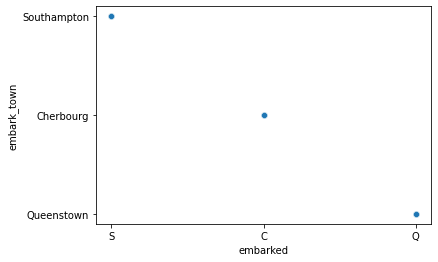

In [42]:
# Distribution of embarked over embark_town using a plot
sns.scatterplot(x='embarked', y='embark_town', data=sql_df)
plt.show()

##### Distribution using a query

In [43]:
# Distribution of embarked over embark_town using a query

# Mapping embarked with embark_town then comparing the two columns with the same values
query = """

SELECT 
    COUNT(REPLACE(REPLACE(REPLACE(embarked, 'S', 'Southampton'), 'C', 'Cherbourg'), 'Q', 'Queenstown')) 
        AS "embarked_fixed NOT IN embark town"
    
FROM titanic

WHERE REPLACE(REPLACE(REPLACE(embarked, 'S', 'Southampton'), 'C', 'Cherbourg'), 'Q', 'Queenstown') 
    NOT IN (embark_town)

"""

execute_query(query)

,embarked_fixed NOT IN embark town
0,0


In [44]:
# Dropping the duplicated column
query = """

ALTER TABLE titanic
    DROP COLUMN embarked

"""

execute_query(query)

Query executed sucessfully: no results to fetch


In [45]:
# Checking the Changes
query = """

SELECT *
FROM titanic

"""

execute_query(query)

,index,survived,pclass,sex,age,fare,class,who,embark_town,alone
0,0,0,3,male,22,7.2500,Third,man,Southampton,False
1,1,1,1,female,38,71.2833,First,woman,Cherbourg,False
2,2,1,3,female,26,7.9250,Third,woman,Southampton,True
3,3,1,1,female,35,53.1000,First,woman,Southampton,False
4,4,0,3,male,35,8.0500,Third,man,Southampton,True
...,...,...,...,...,...,...,...,...,...,...
884,859,0,3,male,30,7.2292,Third,man,Cherbourg,True
885,863,0,3,female,30,69.5500,Third,woman,Southampton,False
886,868,0,3,male,30,9.5000,Third,man,Southampton,True
887,878,0,3,male,30,7.8958,Third,man,Southampton,True


#### pclass and class

In [46]:
# Checking the distribution of the pclass and class columns
query = """

SELECT 
    pclass, class

FROM titanic

"""

execute_query(query)

,pclass,class
0,3,Third
1,1,First
2,3,Third
3,1,First
4,3,Third
...,...,...
884,3,Third
885,3,Third
886,3,Third
887,3,Third


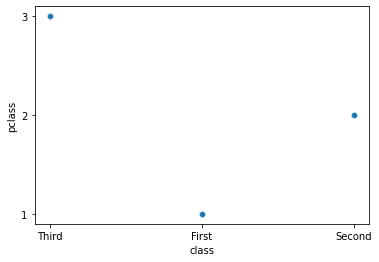

In [47]:
# Distribution of embarked over embark_town using a plot
sns.scatterplot(x='class', y='pclass', data=sql_df)
plt.yticks(range(1,4))
plt.show()

In [48]:
# Distribution of embarked over embark_town using a query

# Mapping class with pclass and comparing the two columns with the same values
query = """

SELECT 
    COUNT(REPLACE(REPLACE(REPLACE(class, 'First', '1'), 'Second', '2'), 'Third', '3')) 
        AS "embarked_fixed NOT IN embark town"
    
FROM titanic

WHERE REPLACE(REPLACE(REPLACE(class, 'First', '1'), 'Second', '2'), 'Third', '3')
    NOT IN (CAST(pclass AS CHAR))

"""

execute_query(query)

,embarked_fixed NOT IN embark town
0,0


In [49]:
# Dropping the duplicated column
query = """

ALTER TABLE titanic
    DROP COLUMN class

"""

execute_query(query)

Query executed sucessfully: no results to fetch


In [50]:
# Checking the changes
query = """

SELECT *
FROM titanic

"""

execute_query(query)

,index,survived,pclass,sex,age,fare,who,embark_town,alone
0,0,0,3,male,22,7.2500,man,Southampton,False
1,1,1,1,female,38,71.2833,woman,Cherbourg,False
2,2,1,3,female,26,7.9250,woman,Southampton,True
3,3,1,1,female,35,53.1000,woman,Southampton,False
4,4,0,3,male,35,8.0500,man,Southampton,True
...,...,...,...,...,...,...,...,...,...
884,859,0,3,male,30,7.2292,man,Cherbourg,True
885,863,0,3,female,30,69.5500,woman,Southampton,False
886,868,0,3,male,30,9.5000,man,Southampton,True
887,878,0,3,male,30,7.8958,man,Southampton,True


### Dealing with Outliers

#### fare

In [51]:
# Summary 
query = """

SELECT 
    round(AVG(fare)) AS average_fare, 
    MIN(fare) AS min_fare, 
    MAX(fare) AS max_fare,
    STDDEV_SAMP(fare) AS std_fare
FROM titanic

"""

execute_query(query)

,average_fare,min_fare,max_fare,std_fare
0,32.0,0.0,512.3292,49.697504


In [52]:
# Checking the distribution
query = """

SELECT fare
FROM titanic

"""

execute_query(query)

,fare
0,7.2500
1,71.2833
2,7.9250
3,53.1000
4,8.0500
...,...
884,7.2292
885,69.5500
886,9.5000
887,7.8958


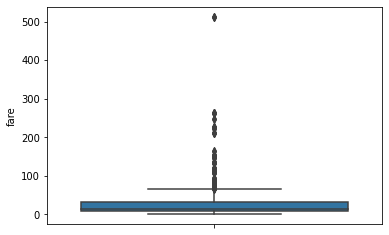

In [53]:
# Distribution of fare using a box plot
sns.boxplot(y='fare', data=sql_df)
plt.show()

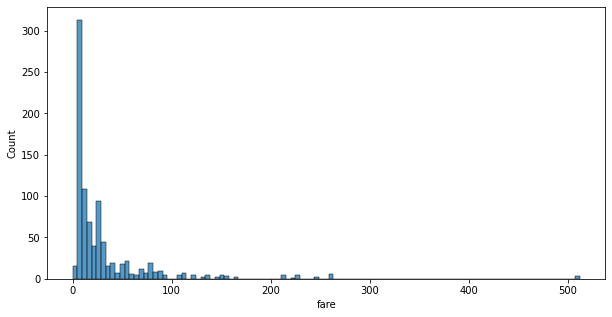

In [54]:
# Distribution of fare using a histogram plot
plt.figure(figsize=(10, 5))
sns.histplot(x='fare', data=sql_df)
plt.show()

In [55]:
# Distribution of fare-who using a query
query = """

SELECT 
    fare, who
FROM titanic

"""

execute_query(query)

,fare,who
0,7.2500,man
1,71.2833,woman
2,7.9250,woman
3,53.1000,woman
4,8.0500,man
...,...,...
884,7.2292,man
885,69.5500,woman
886,9.5000,man
887,7.8958,man


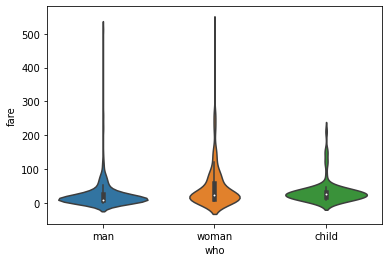

In [56]:
# Distribution of fare-who using a violin plot
sns.violinplot(x='who', y='fare', data=sql_df)
plt.show()

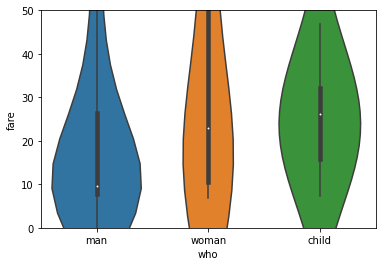

In [57]:
# Distribution of fare-who using a violin plot
sns.violinplot(x='who', y='fare', data=sql_df)
# Zoom in
plt.ylim(0, 50)
plt.show()

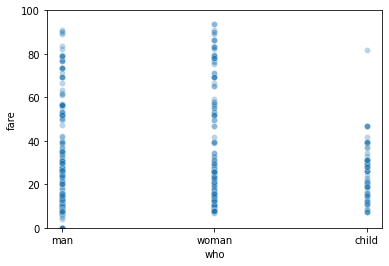

In [58]:
# Distribution of fare-who using a scatter plot
sns.scatterplot(x='who', y='fare', data=sql_df, alpha=0.3)
# Zoom in
plt.ylim(0, 100)
plt.show()

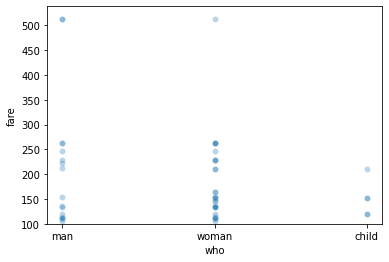

In [59]:
# Distribution of fare-who using a scatter plot
sns.scatterplot(x='who', y='fare', data=sql_df, alpha=0.3)
# Zoom in
plt.ylim(100)
plt.show()

In [60]:
# Query to define the variable 'q' for filtering values using the 95th percentile
query = f"""

SELECT 
    PERCENTILE_DISC(0.95) WITHIN GROUP (ORDER BY fare) AS "95th_percentile"
FROM titanic

"""

execute_query(query)

,95th_percentile
0,113.275


In [61]:
# Defining the variable for filtering
(q := sql_df.iloc[0,0])

113.275

In [62]:
# Selecting values lower than 95th percentile
query = f"""

SELECT 
    fare, who
FROM titanic
WHERE fare <= {q}

"""

execute_query(query)

,fare,who
0,7.2500,man
1,71.2833,woman
2,7.9250,woman
3,53.1000,woman
4,8.0500,man
...,...,...
842,7.2292,man
843,69.5500,woman
844,9.5000,man
845,7.8958,man


In [63]:
# Removing the outliers higher than 95th percentile
query = f"""

DELETE FROM titanic 
WHERE fare > {q}

"""

execute_query(query)

Query executed sucessfully: no results to fetch


In [64]:
# Checking changes
query = f"""

SELECT 
    fare, who
FROM titanic

"""

execute_query(query)

,fare,who
0,7.2500,man
1,71.2833,woman
2,7.9250,woman
3,53.1000,woman
4,8.0500,man
...,...,...
842,7.2292,man
843,69.5500,woman
844,9.5000,man
845,7.8958,man


### Check for Duplicated Rows

In [65]:
# Length before applying 'drop_duplicates' method
query = f"""

SELECT 
    *
FROM titanic

"""

len(execute_query(query))

847

In [66]:
# Length after applying 'drop_duplicates' method
len(sql_df.drop_duplicates())

847

# Pre-Modeling

In [67]:
# Dropping first column (index)
(sql_df := sql_df.iloc[:,1:])

,survived,pclass,sex,age,fare,who,embark_town,alone
0,0,3,male,22,7.2500,man,Southampton,False
1,1,1,female,38,71.2833,woman,Cherbourg,False
2,1,3,female,26,7.9250,woman,Southampton,True
3,1,1,female,35,53.1000,woman,Southampton,False
4,0,3,male,35,8.0500,man,Southampton,True
...,...,...,...,...,...,...,...,...
842,0,3,male,30,7.2292,man,Cherbourg,True
843,0,3,female,30,69.5500,woman,Southampton,False
844,0,3,male,30,9.5000,man,Southampton,True
845,0,3,male,30,7.8958,man,Southampton,True


In [68]:
# Information about the dataframe
sql_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     847 non-null    int64  
 1   pclass       847 non-null    int64  
 2   sex          847 non-null    object 
 3   age          847 non-null    int64  
 4   fare         847 non-null    float64
 5   who          847 non-null    object 
 6   embark_town  847 non-null    object 
 7   alone        847 non-null    bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 47.3+ KB


In [69]:
# Convert the object columns and bool columns to numeric columns
for col in sql_df.columns:
    # Checking column data type, proceed if object or bool 
    if sql_df[col].dtypes == 'object' or sql_df[col].dtypes == 'bool': 
        # List of unique values
        list_unique = sql_df[col].unique()
        # Sort the list
        list_unique.sort()
        # Proceed to format the column if count of unique values is less than 5
        if len(list_unique) < 5:
            # Create a dictionary from the list_unique, index:unique_value
            dict_index_unique = dict(enumerate(list_unique))
            # Revert the dictionary, unique_value:index
            dict_unique_index = {unique_value:index for index, unique_value in dict_index_unique.items()}
            print (dict_unique_index)
            # Map the dictionary in the column
            sql_df[col] = sql_df[col].apply(lambda x: dict_unique_index[x])     

{'female': 0, 'male': 1}
{'child': 0, 'man': 1, 'woman': 2}
{'Cherbourg': 0, 'Queenstown': 1, 'Southampton': 2}
{False: 0, True: 1}


In [70]:
sql_df.dtypes

survived         int64
pclass           int64
sex              int64
age              int64
fare           float64
who              int64
embark_town      int64
alone            int64
dtype: object

In [71]:
sql_df

,survived,pclass,sex,age,fare,who,embark_town,alone
0,0,3,1,22,7.2500,1,2,0
1,1,1,0,38,71.2833,2,0,0
2,1,3,0,26,7.9250,2,2,1
3,1,1,0,35,53.1000,2,2,0
4,0,3,1,35,8.0500,1,2,1
...,...,...,...,...,...,...,...,...
842,0,3,1,30,7.2292,1,0,1
843,0,3,0,30,69.5500,2,2,0
844,0,3,1,30,9.5000,1,2,1
845,0,3,1,30,7.8958,1,2,1


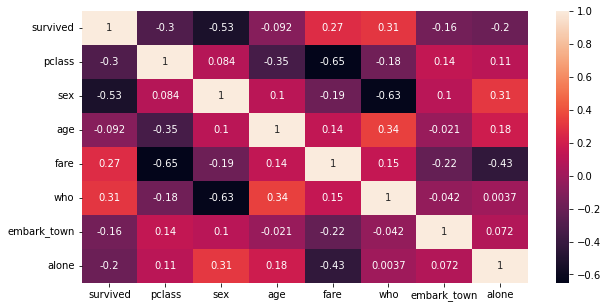

In [78]:
# Correlation matrix
plt.figure(figsize=(10, 5))
sns.heatmap(sql_df.corr(), annot=True)
plt.show()

# 'survived' has a slight correlation with 'who' and 'fare'

# Modeling

In [79]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [80]:
# Define features and target
(X := sql_df.drop('survived', axis=1),
y := sql_df['survived'])

(     pclass  sex  age     fare  who  embark_town  alone
 0         3    1   22   7.2500    1            2      0
 1         1    0   38  71.2833    2            0      0
 2         3    0   26   7.9250    2            2      1
 3         1    0   35  53.1000    2            2      0
 4         3    1   35   8.0500    1            2      1
 ..      ...  ...  ...      ...  ...          ...    ...
 842       3    1   30   7.2292    1            0      1
 843       3    0   30  69.5500    2            2      0
 844       3    1   30   9.5000    1            2      1
 845       3    1   30   7.8958    1            2      1
 846       3    0   30  23.4500    2            2      0
 
 [847 rows x 7 columns],
 0      0
 1      1
 2      1
 3      1
 4      0
       ..
 842    0
 843    0
 844    0
 845    0
 846    0
 Name: survived, Length: 847, dtype: int64)

In [123]:
# Split the data set into training and test, with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [124]:
# Shape of the matrix
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((635, 7), (212, 7), (635,), (212,))

In [125]:
# Create the model instance
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [126]:
# Fit the data into the model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

# Evaluate

In [127]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [128]:
# Make the prediction
y_pred = model.predict(X_test)

In [129]:
# Create the data frame
df_results = pd.DataFrame(columns=["Prediction Rate",'Misclassification Rate'])

# Calculate the prediction rate
pred_rate = accuracy_score(y_test, y_pred)
# Calculate the misclassification rate
misclass_rate = abs(accuracy_score(y_test, y_pred)-1)

# Insert predictions into the data frame
df_results['Prediction Rate'] = [pred_rate]
df_results['Misclassification Rate'] = [misclass_rate]

# Display the data frame
df_results

,Prediction Rate,Misclassification Rate
0,0.825472,0.174528


In [130]:
# Create a confusion matrix
pd.DataFrame(data=confusion_matrix(y_test, y_pred), columns=['Predicted Not Alive', 'Predicted Alive'], index=['True Not Alive', 'True Alive'])

,Predicted Not Alive,Predicted Alive
True Not Alive,118,10
True Alive,27,57
